In [3]:
%pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 11.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


### 오토인코더
오토인코더는 라벨 없이 원하는 출력값을 생성하는 모델이다. 

따라서 파라미터들을 학습하기 위해 라벨을 사용하지 않는 비지도 학습(unsupervised learning)에 속한다. 오토인코더는 많은 연구에 기반이 되는 기본적인 비지도 학습(unsupervised learning) 모델 중 하나다.

#### 1. 라이브러리 호출 및 연산 타입 확인

In [4]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f'{device} is available.')

mps is available.


#### 2. MNIST 데이터 불러오기

In [6]:
# transform=transforms.ToTensor() -> 불러온 MNIST 이미지 데이터는 원래 [0, 255] 범위의 픽셀 값인데, ToTensor()를 사용하면 [0, 1] 사이로 정규화되면서 텐서로 바뀐다.
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())

# 트레인 데이터셋을 50개씩 묶어서 학습할 때 사용할 수 있는 형태로 만들어준다.
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.15MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.85MB/s]


#### 3. 오토인코더 모델 생성

Autoencoder(오토인코더)는 이미지를 압축하고(encoder), 다시 복원하는(decoder) 신경망이다.

아래 오토인코더 모델은 MNIST처럼 28x28(784픽셀로 이루어진 벡터)인 흑백 이미지를 압축해서 아주 작은 벡터(10차원)로 만들고, 그걸 다시 원래 28X28 이미지로 복원한다.

728개의 정보를 10개의 정보만 남게 요약한 것이다.

원래 MNIST 한 장은 "아주 섬세한 고해상도 사진"이다. 그런데 이 사진을 "검정 배경에 3 모양이 있는 것 간은" 정도만 남기고 싶은거다. 그래서 사진을 요약하는 10개의 특성만 뽑은 것이다.

이 10개의 숫자가 "10차원 벡터"이다.

##### 왜 차원(D)이라는 단어를 사용할까?

벡터는 방향 + 크기를 가진 수학적 대상이다. 벡터의 길이(속성 수)가 10개면 -> 10차원 공간에 있는 점이라고 부른다.(x1, x2, x3, …, x10) 이런 식으로 10개 숫자가 있는 셈이다.

```plaintest
Input Image (28x28x1)
↓ Conv2d
14x14x16
↓ Conv2d
6x6x32
↓ Conv2d
4x4x64
↓ Flatten
(1024)
↓ Linear
(10) ← 압축 끝!

(디코딩 시작)
↓ Linear
(1024)
↓ Unflatten
4x4x64
↓ ConvTranspose2d
6x6x32
↓ ConvTranspose2d
14x14x16
↓ ConvTranspose2d
28x28x1
Output Image (28x28x1)
```

In [ ]:
class Flatten(nn.Module): # 4D -> 2D로 계산하기 (Fully Connected Layer을 쓰려면 2D로 변경해야한다.)
    def forward(self, x):
        batch_size = x.shape[0]

        return x.view(batch_size, -1) # (배치 수, 채널 수, 이미지 높이, 이미지 너비) -> (배치 수, 채널 수*이미지 너비*이미지 높이)

class Unflatten(nn.Module): # 2D -> 4D로 계산하기

    def __init__(self, k): # k: 채널 수
        super(Unflatten, self).__init__()

        self.k = k
        
    def forward(self, x):
        # Flatten()을 지나온 tensor이다. 즉, 원래 4D (batch, channel, height, width) 였던걸 -> (batch_size, 벡터 길이)로 바꾼 형태이다. 
        # s[0]: # 배치 수
        # s[1]: # 벡터 사이즈(길이)
        s = x.size()
        
        # 벡터 사이즈 = 채널 수*이미지 너비*이미지 높이
        # 벡터 사이즈 = 채널 수*이미지 사이즈(=이미지 너비=이미지 높이)**2 (MNIST의 경우에는 정사각형이므로)
        # 이미지 사이즈 = (벡터 사이즈//채널 수)**.5
        feature_size = int((s[1]//self.k)**.5) 
        
        return x.view(s[0],self.k,feature_size,feature_size) # (배치 수, 채널 수*이미지 너비*이미지 높이) -> (배치 수, 채널 수, 이미지 높이, 이미지 너비) 형태로 다시 바꿔준다.
    
# Autoencoder는 이미지를 압축(encoder)하고 복원(decoder)하는 구조이다.
# 목적: 데이터를 요약하고, 중요한 특징만 뽑아내기 위함이다.
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        k = 16 # 초기 채널 수. 뒤에서 16 -> 32 -> 64 채널로 확장된다.
        # MNIST 데이터셋은 흑백으로 채널 수는 1이다. 더 많은 특징을 뽑아 내기 위해서 채널 수 을 늘려준다.
        # 다운샘플링 -> 데이터(특히 이미지)의 크기를 줄여서 계산을 효율적으로 하고 중요한 특징만 남긴다.
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, k, 3, stride=2), # stride=2를 적용 함으로써 다운샘플링한다.
                        nn.ReLU(), 
                        nn.Conv2d(k, 2*k, 3, stride=2),
                        nn.ReLU(), 
                        nn.Conv2d(2*k, 4*k, 3, stride=1),
                        nn.ReLU(),
                        Flatten(),
                        nn.Linear(1024, 10), # 1024개 피처를 10차원짜리 벡터로 압축
                        nn.ReLU()
        )
        
        # ConvTranspose2d
        # 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출한다.
        # 출력 된 벡터는 행렬 형태로 변환한다.
        self.decoder = nn.Sequential(
                        nn.Linear(10, 1024),
                        nn.ReLU(),
                        Unflatten(4*k),
                        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), # (입력 채널 수, 출력 채널 수, 필터 크기, stride)
                        nn.ReLU(),
                        nn.ConvTranspose2d(2*k, k, 3, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(k, 1, 3, stride=2,output_padding=1) # output_padding=1 -> stride=2 때문에 크기 맞추려고 보정
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [9]:
model = Autoencoder().to(device)

#### 4. 시각화 함수 만들기

In [ ]:
def normalize_output(img):
    # 이미지의 픽셀 값 범위를 [0, 1] 사이로 정규화(normalization)하는 함수다.
    # 시각화할 때 값이 0~1 범위에 있어야 matplotlib이 제대로 보여줄 수 있다.
    img = (img - img.min())/(img.max()-img.min())

    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            
            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지

            break # 배치 하나만 받고 for문 종료 -> 샘플 확보를 위한 것이므로

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비 
    rows = 5 # 시각화 전체 높이 

    fig = plt.figure(figsize=(8,4)) # figure 선언

    # 원본 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze()) 
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
    plt.show()

    # 생성(복원) 이미지 배치 크기 만큼 보여주기
    fig=plt.figure(figsize=(8,4))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

#### 5. 손실 함수 및 최적화 방법 정의

In [12]:
criterion = nn.MSELoss() # MSE 사용 (예측 문제이므로)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#### 6. 오토인코더 학습하기

[1] loss: 0.052


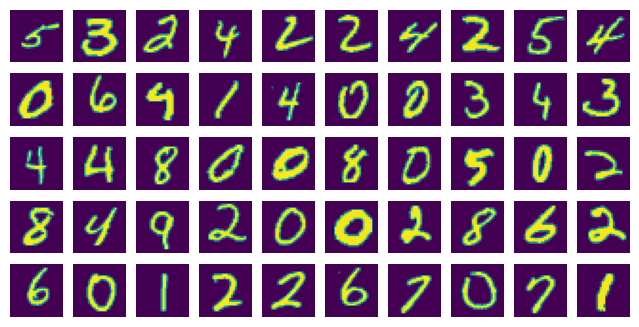

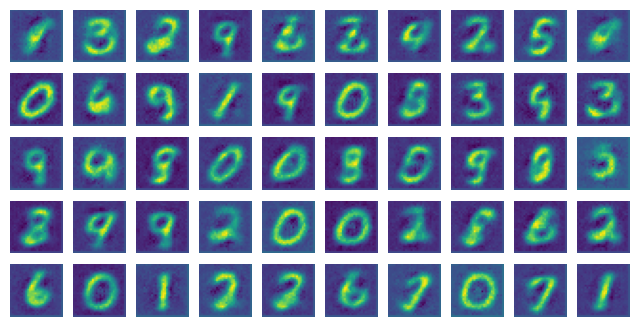

[11] loss: 0.023


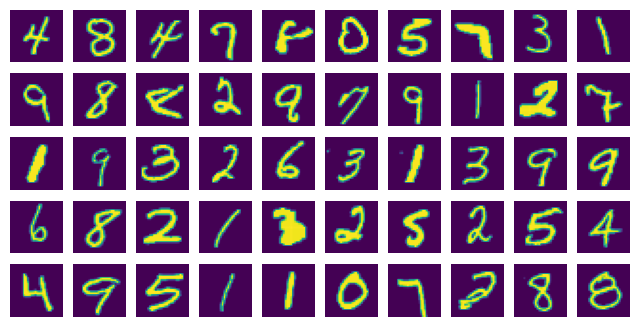

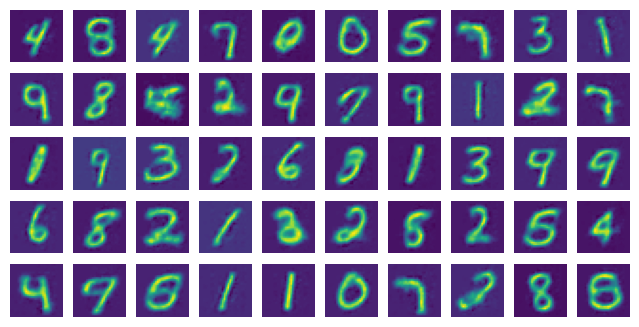

[21] loss: 0.021


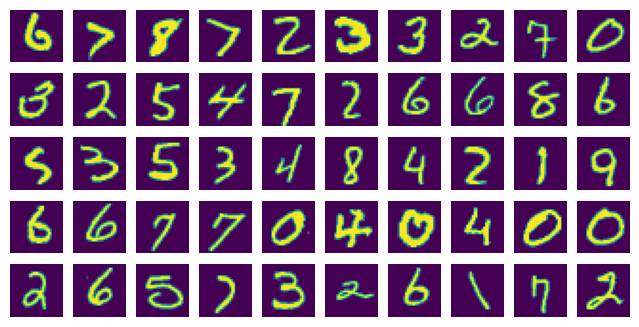

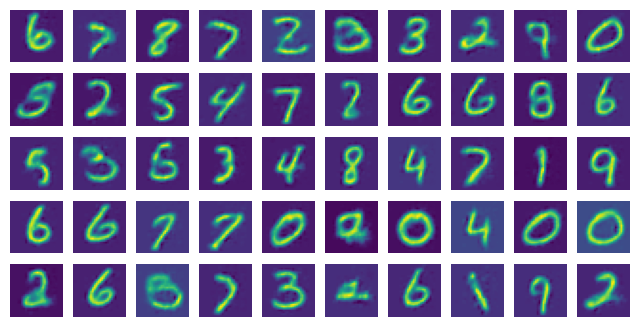

In [ ]:
for epoch in range(21):
    running_loss = 0.0

    for data in trainloader:
        inputs = data[0].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward() # 역전파로  gradient 계산
        optimizer.step() # optimizer가 모델 가중치 업데이트
        running_loss += loss.item()

    cost = running_loss / len(trainloader)        
    
    if epoch % 10 == 0:
        print('[%d] loss: %.3f' %(epoch + 1, cost))  
        check_plot()

# 학습마다 [가중치(weight)들을 조금씩 수정](= Gradient Descent)해서 수정한 가중치로 다시 예측해보는 식으로 진행한다.
# 결과를 보면 loss가 줄어드는 것을 알 수 있다.
# 이 경우에는 초기의 흐릿한 입력 이미지를 복원하는 게 목표이므로, 학습하면서 loss를 줄여나가면서 "이 부분은 어둡게", "이 부분은 밝게" 하면서 원본에 비슷하게 그리게 된다.
